# Network Anomaly Detection

## Contributors

#### Amr Yasser 6772
#### Elhussein Sabri 6716
#### Marwan Khaled 7020


## References 
https://www.ecb.torontomu.ca/~bagheri/papers/cisda.pdf (Detailed Analysis of the KDD CUP 99 Data Set Mahbod Tavallaee, Ebrahim Bagheri, Wei Lu, and Ali A. Ghorban)  

https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html  

https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

## Download Datset 

You can Import data set from 
* [KDD CUP 1999 DATA](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)
or Download it from kaggle

### Imports

In [65]:
import os
from time import time

# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph as knn
from sklearn.metrics.pairwise import rbf_kernel as rbf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics.cluster import contingency_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy
from tabulate import tabulate
from sklearn.cluster import kmeans_plusplus
from sklearn.neighbors import NearestNeighbors

## CoLab

In [3]:
from google.colab import drive

# mount drive
drive.mount('/content/drive')

path_train = '/content/drive/MyDrive/Network Anomaly Detection/kddcup.data_10_percent.gz'
path_test = '/content/drive/MyDrive/Network Anomaly Detection/corrected.gz'
path_all = '/content/drive/MyDrive/Network Anomaly Detection/kddcup.data.gz'

Mounted at /content/drive


## Kaggle

In [ ]:
path_train = ''
path_test = ''

### Utils

In [4]:
def plot(x,y,title):
    plt.figure(figsize=(8,6))
    plt.bar(x,y)
    plt.title(title)
    plt.xlabel('Clusters')
    plt.ylabel('Counts')
    plt.show()

def analyze(model,ground_truth,pred,k):
    print(f'K-Means at k = {model.n_clusters} after {model.execution_time}s:\n')
    labels , counts = np.unique(model.labels,return_counts=True)
    plot(labels,counts,f'Clustering counts at k = {model.n_clusters} after {model.iterations} iterations')

    labels, counts = np.unique(pred,return_counts = True)

    precisions,recalls,fscores = accuracy_scores(ground_truth,pred)
    data = []
    dist = []
    for i in range(k):
      dist.append([i,counts[i]])
      data.append([i,precisions[i],recalls[i],fscores[i]])

    print("\nClusters distribution")
    print(f'{tabulate(dist, headers=["Cluster", "Samples"],tablefmt="psql")}')
    
    print("\nAccuracy measures")
    print(f'{tabulate(data, headers=["Cluster", "Precision", "Recall", "F-Score"],tablefmt="psql")}')
    print(f'\nF1-Score: {np.sum(fscores/k)}')
    print(f'Clustering conditional entropy: {conditional_entropy(ground_truth,pred)}')


def cluster(k,init='++',mode='kmeans',sim='nn',nn=10,gamma=1.0):
  if mode == 'kmeans':
    model = KMeans(n_clusters = k,init = init).fit(train)
    pred = model.predict(test)
    analyze(model,ground_truth,pred,k)

  elif mode == 'spectral':
    model = NCut(trainN,k, similarity=sim, nn=nn, gamma=gamma)
    analyze(model,ground_truthN,model.labels,k)

# K-Means Implemenetation

In [5]:
# Define the K-Means algorithm
class KMeans:
    def __init__(self,n_clusters=3, init='++', max_iter=300,centroids=[]):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.init = init
        self.centroids = np.array(centroids)
        self.iterations = 0
    
    def fit(self,train,random_state = None):
        start = time()

        # Initialize centroids randomly
        if len(self.centroids) == 0:
          if self.init == '++':
            self.centroids, indices = kmeans_plusplus(train, n_clusters=self.n_clusters,random_state = random_state)
          elif self.init == 'random':
            self.centroids = np.array(train[np.random.choice(train.shape[0], self.n_clusters, replace=False)])   
          else:
            print('Init method not applicable')
            return
        
        prev_centroids = np.zeros(self.centroids.shape)
        self.labels = np.zeros(len(train),dtype='int8')

        while np.not_equal(self.centroids, prev_centroids).any() and self.iterations < self.max_iter:
            prev_centroids = self.centroids.copy()

            # Assign each point to the closest centroid
            distances = np.sqrt(((train - self.centroids[:, np.newaxis])**2).sum(axis=2))
            self.labels = np.argmin(distances, axis=0)

            # Update centroids
            for i in range(self.n_clusters):
                points = train[self.labels == i]
                if len(points) > 0:
                  self.centroids[i] = np.mean(points, axis=0)

            # Catch any np.nans, resulting from a centroid having no points
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  
                    self.centroids[i] = prev_centroids[i]
            
            self.iterations += 1

        end = time()
        self.execution_time = end - start
        
        return self
    
    def predict(self,X):
        predicted = []
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        predicted = np.argmin(distances, axis=0)
        return np.array(predicted)

# Normalized Cuts Implementation

In [6]:
# Define the Normalized Cuts algorithm
def NCut(train, k, nn=10, similarity= 'nn', gamma=1.0):
    # Compute the similarity matrix
    if similarity == 'nn':
      sim = knn(train,nn,mode='connectivity').toarray()
      A = sim + sim.T
    elif similarity == 'rbf':
      sim = rbf(train,train,gamma)
      A = sim
    else:
      print('Similarity method not applicable')
      return

    # Compute the diagonal degree matrix
    D = np.diag(np.sum(sim, axis=1)) 

    # Compute the Laplacian matrix
    L = D - A

    B = np.dot(np.linalg.inv(D),L)

    eigenvalues,eigenvectors = np.linalg.eigh(B)

    U = eigenvectors[:,:k]

    Y = Normalizer().fit_transform(U)
    
    # Cluster the normalized eigenvectors using K-Means
    model = KMeans(n_clusters = k).fit(Y, random_state = 42)

    return model

# Evaluation Implementation

In [7]:
# Conditional Entropy
def conditional_entropy(ground_truth,clusters):
  con = contingency_matrix(ground_truth,clusters)

  clusters_entropies = []

  for cluster in con.T:
    pT = cluster/np.sum(cluster)
    clusters_entropies.append((np.sum(cluster)/len(ground_truth)) * entropy(pT,base=2))
  
  return np.sum(clusters_entropies)

# Precision, Recall, F1-Score
def accuracy_scores(ground_truth,clusters):
  con = contingency_matrix(ground_truth,clusters)

  labels , counts = np.unique(ground_truth,return_counts=True)
  n_clusters = len(np.unique(clusters))
  precision = []
  recall = []
  for cluster in con.T:
    precision.append(cluster.max()/cluster.sum())
    label = np.argmax(cluster)
    recall.append(cluster[label]/counts[label])
  
  precision = np.array(precision)
  recall = np.array(recall)
  
  return precision,recall,(2*precision*recall)/(precision+recall)

# Extracting Data and formatting

In [8]:
# Open and read the compressed data file using gzip
with gzip.open(path_train, 'rb') as f:
    train_data = pd.read_csv(f, header=None)
    

with gzip.open(path_test, 'rb') as f:
    test_data = pd.read_csv(f, header=None)
    
with gzip.open(path_all, 'rb') as f:
    train_all_data = pd.read_csv(f, header=None)

# Add column names to the DataFrame
cols = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]


train_data.columns  = cols
test_data.columns= cols
train_all_data.columns = cols

# removing the 2 samples with service = icmp as they do not match in train data
test_data = test_data[test_data.service != 'icmp']

ground_truth = LabelEncoder().fit_transform(test_data['label'])


train_data.drop('label',axis=1,inplace=True)
test_data.drop('label',axis=1,inplace=True)

train_all_y = train_all_data['label']
train_all_data.drop('label',axis=1,inplace=True)

trainN,_,trainN_y,_ = train_test_split(train_all_data,train_all_y,train_size=0.0025, random_state = 42, stratify = train_all_y)
ground_truthN = LabelEncoder().fit_transform(trainN_y)


### Pre Processing


In [9]:
# Convert categorical features to numerical features
train_categorical_columns = train_data.select_dtypes(include=['object']).columns

for col in train_categorical_columns:
    le = LabelEncoder().fit(train_data[col])

    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    trainN[col] = LabelEncoder().fit_transform(trainN[col])


scaler = MinMaxScaler().fit(train_data)

train = scaler.transform(train_data)
test = scaler.transform(test_data)


# Clustering Using K-Means

K-Means at k = 7 after 19.846527338027954s:




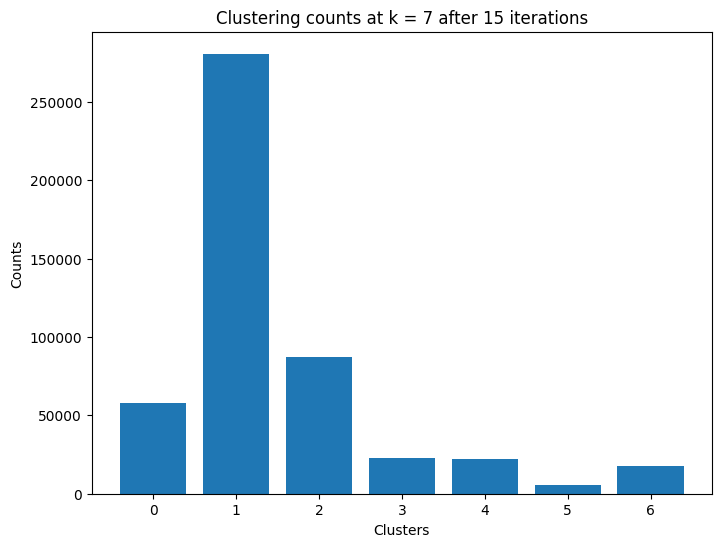



Clusters distribution

+-----------+-----------+

|   Cluster |   Samples |

|-----------+-----------|

|         0 |     47738 |

|         1 |    164704 |

|         2 |     18174 |

|         3 |     43466 |

|         4 |     29153 |

|         5 |       480 |

|         6 |      7312 |

+-----------+-----------+



Accuracy measures

+-----------+-------------+----------+-----------+

|   Cluster |   Precision |   Recall |   F-Score |

|-----------+-------------+----------+-----------|

|         0 |    0.798965 | 0.629483 |  0.70417  |

|         1 |    0.996084 | 0.999805 |  0.997941 |

|         2 |    0.960438 | 0.300943 |  0.458287 |

|         3 |    0.932798 | 0.69904  |  0.799176 |

|         4 |    0.580695 | 0.279398 |  0.377273 |

|         5 |    0.55     | 0.332494 |  0.414443 |

|         6 |    0.649754 | 0.078411 |  0.139935 |

+-----------+-------------+----------+-----------+



F1-Score: 0.5558891910851097

Clustering conditional entropy: 0.4724252038768968


In [ ]:
# kmeans clustering with k = 7
cluster(7)

K-Means at k = 15 after 26.537365198135376s:




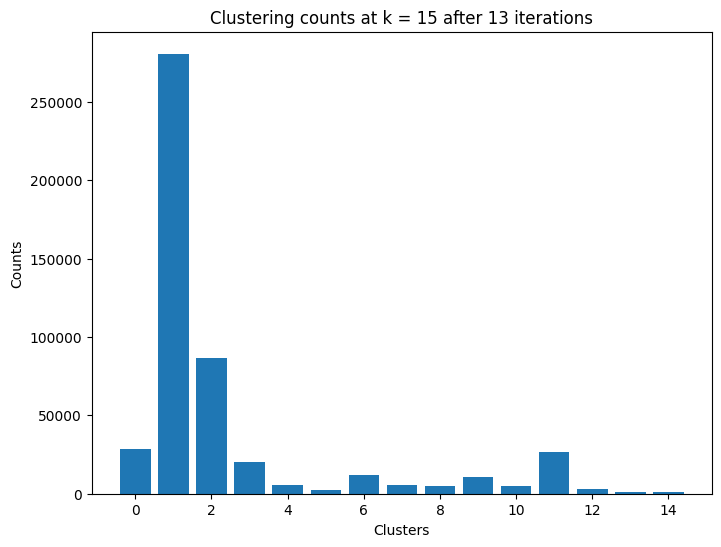



Clusters distribution

+-----------+-----------+

|   Cluster |   Samples |

|-----------+-----------|

|         0 |     19585 |

|         1 |    164523 |

|         2 |     18026 |

|         3 |     41318 |

|         4 |       596 |

|         5 |      1519 |

|         6 |     25666 |

|         7 |       424 |

|         8 |      2030 |

|         9 |      3549 |

|        10 |      2717 |

|        11 |     26653 |

|        12 |      2197 |

|        13 |      1803 |

|        14 |       421 |

+-----------+-----------+



Accuracy measures

+-----------+-------------+-----------+-----------+

|   Cluster |   Precision |    Recall |   F-Score |

|-----------+-------------+-----------+-----------|

|         0 |    1        | 0.323233  | 0.48855   |

|         1 |    0.996086 | 0.998708  | 0.997395  |

|         2 |    0.968268 | 0.300926  | 0.459153  |

|         3 |    0.981146 | 0.698936  | 0.816339  |

|         4 |    0.689597 | 0.251684  | 0.368775  |

|         5 |    

In [ ]:
# kmeans clustering with k = 15
cluster(15)

K-Means at k = 23 after 187.69003057479858s:




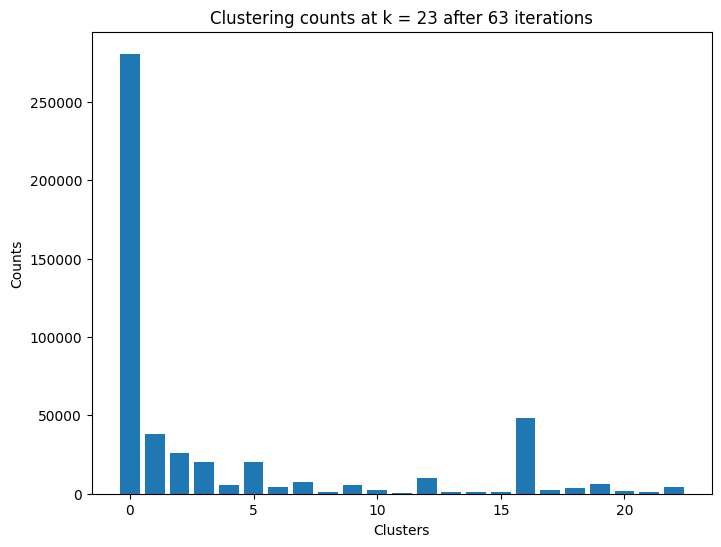



Clusters distribution

+-----------+-----------+

|   Cluster |   Samples |

|-----------+-----------|

|         0 |    164609 |

|         1 |     12230 |

|         2 |     25895 |

|         3 |     41233 |

|         4 |       593 |

|         5 |     13871 |

|         6 |       269 |

|         7 |     22851 |

|         8 |       398 |

|         9 |      2204 |

|        10 |      1880 |

|        11 |       651 |

|        12 |      7166 |

|        13 |       419 |

|        14 |        46 |

|        15 |      1803 |

|        16 |      5809 |

|        17 |      2094 |

|        18 |       577 |

|        19 |      2798 |

|        20 |       617 |

|        21 |       260 |

|        22 |      2754 |

+-----------+-----------+



Accuracy measures

+-----------+-------------+-------------+------------+

|   Cluster |   Precision |      Recall |    F-Score |

|-----------+-------------+-------------+------------|

|         0 |    0.996082 | 0.999226    | 0.997651   |

|

In [ ]:
# kmeans clustering with k = 23
cluster(23)

K-Means at k = 31 after 123.22605752944946s:




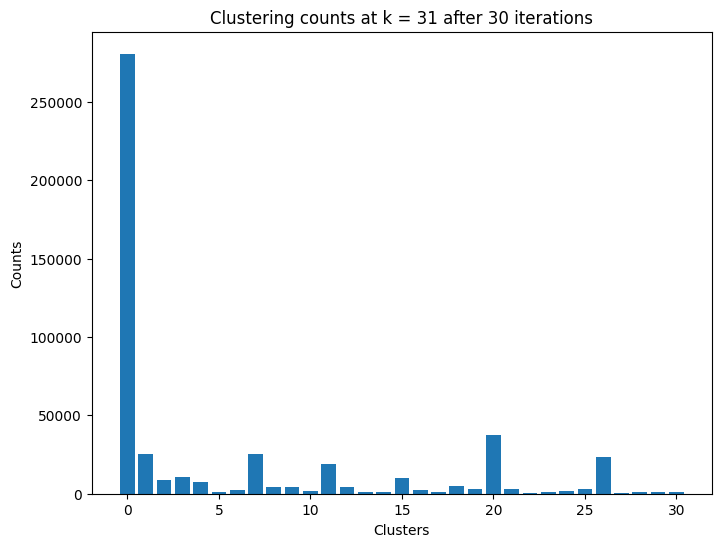



Clusters distribution

+-----------+-----------+

|   Cluster |   Samples |

|-----------+-----------|

|         0 |    164567 |

|         1 |      3860 |

|         2 |      6318 |

|         3 |     21135 |

|         4 |     22818 |

|         5 |        87 |

|         6 |      2012 |

|         7 |     25627 |

|         8 |      1624 |

|         9 |        24 |

|        10 |       725 |

|        11 |     13144 |

|        12 |       843 |

|        13 |       248 |

|        14 |       412 |

|        15 |     20076 |

|        16 |       857 |

|        17 |      1692 |

|        18 |      2269 |

|        19 |       235 |

|        20 |     11461 |

|        21 |      1823 |

|        22 |       182 |

|        23 |        46 |

|        24 |      1798 |

|        25 |      2114 |

|        26 |      2658 |

|        27 |       650 |

|        28 |       231 |

|        29 |       920 |

|        30 |       571 |

+-----------+-----------+



Accuracy measures

+--------

In [ ]:
# kmeans clustering with k = 31
cluster(31)

K-Means at k = 45 after 220.23847556114197s:




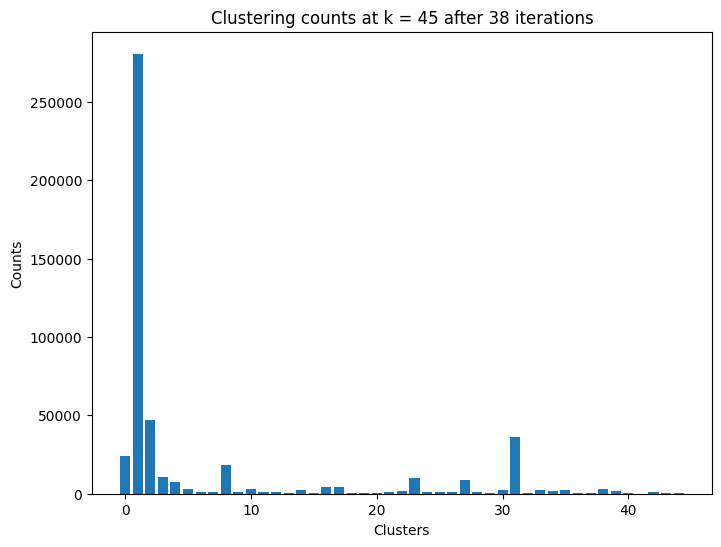



Clusters distribution

+-----------+-----------+

|   Cluster |   Samples |

|-----------+-----------|

|         0 |     24344 |

|         1 |    150366 |

|         2 |      5464 |

|         3 |     21111 |

|         4 |     22804 |

|         5 |       235 |

|         6 |       555 |

|         7 |       416 |

|         8 |     12684 |

|         9 |       680 |

|        10 |       170 |

|        11 |       694 |

|        12 |      1692 |

|        13 |       212 |

|        14 |      1318 |

|        15 |       403 |

|        16 |        30 |

|        17 |      2653 |

|        18 |       617 |

|        19 |        41 |

|        20 |       430 |

|        21 |       411 |

|        22 |       633 |

|        23 |     20077 |

|        24 |     15679 |

|        25 |       230 |

|        26 |       101 |

|        27 |      6166 |

|        28 |       443 |

|        29 |       178 |

|        30 |      1976 |

|        31 |     11336 |

|        32 |       194 |

|  

In [ ]:
# kmeans clustering with k = 45
cluster(45)

# Clustering Using Normalized cut

## Using K-NN

K-Means at k = 23 after 0.41596150398254395s:




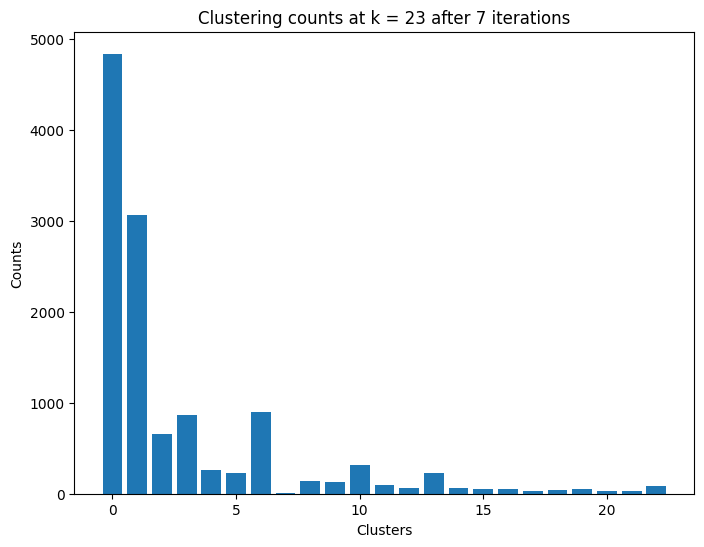



Clusters distribution

+-----------+-----------+

|   Cluster |   Samples |

|-----------+-----------|

|         0 |      4842 |

|         1 |      3065 |

|         2 |       656 |

|         3 |       861 |

|         4 |       265 |

|         5 |       228 |

|         6 |       895 |

|         7 |        11 |

|         8 |       144 |

|         9 |       131 |

|        10 |       319 |

|        11 |        93 |

|        12 |        64 |

|        13 |       228 |

|        14 |        60 |

|        15 |        53 |

|        16 |        49 |

|        17 |        33 |

|        18 |        44 |

|        19 |        55 |

|        20 |        32 |

|        21 |        33 |

|        22 |        85 |

+-----------+-----------+



Accuracy measures

+-----------+-------------+------------+------------+

|   Cluster |   Precision |     Recall |    F-Score |

|-----------+-------------+------------+------------|

|         0 |    1        | 0.689744   | 0.816388   |

|    

In [ ]:
cluster(23, mode='spectral', nn = 10)

## Using RBF Kernel

K-Means at k = 23 after 0.2575039863586426s:




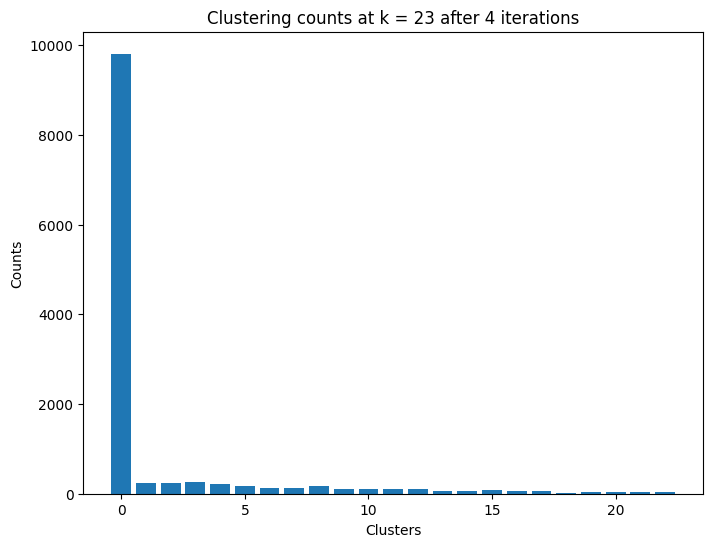



Clusters distribution

+-----------+-----------+

|   Cluster |   Samples |

|-----------+-----------|

|         0 |      9811 |

|         1 |       247 |

|         2 |       230 |

|         3 |       259 |

|         4 |       215 |

|         5 |       173 |

|         6 |       117 |

|         7 |       123 |

|         8 |       162 |

|         9 |       110 |

|        10 |        96 |

|        11 |       116 |

|        12 |       116 |

|        13 |        52 |

|        14 |        56 |

|        15 |        80 |

|        16 |        53 |

|        17 |        52 |

|        18 |        23 |

|        19 |        46 |

|        20 |        44 |

|        21 |        29 |

|        22 |        36 |

+-----------+-----------+



Accuracy measures

+-----------+-------------+------------+-----------+

|   Cluster |   Precision |     Recall |   F-Score |

|-----------+-------------+------------+-----------|

|         0 |    0.713485 | 0.997151   | 0.831798  |

|        

In [ ]:
cluster(23, mode='spectral', sim='rbf', gamma = 1.0)

# DBSCAN - New Clustering Algorithm <Clustering Techinque>

## Parameters Estimation

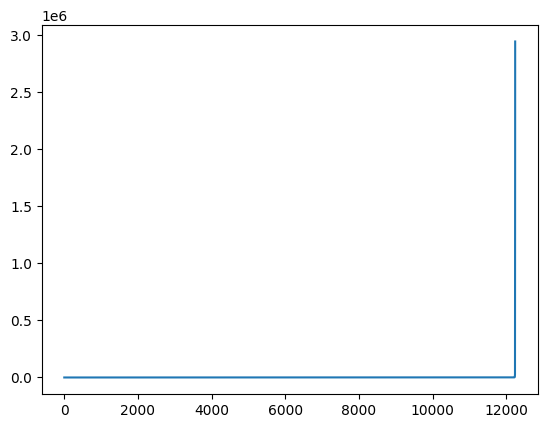

(0.0, 40000.0)

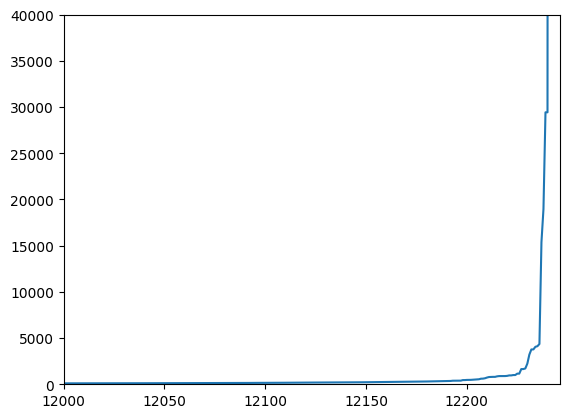

In [75]:
# estimating epsilon using nearest neighbors graph
# it was found to be 0.5 'normalized'
# also min samples will be equal to 2*D = 82
neighbors = NearestNeighbors(n_neighbors=82)
neighbors_fit = neighbors.fit(trainN)
distances, indices = neighbors_fit.kneighbors(trainN)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()
plt.plot(distances)
plt.xlim(12000, trainN.shape[0])
plt.ylim(0, 0.04*1000000)

In [77]:
class DBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
    
    def fit(self, X):
        start = time()
        self.labels = np.zeros(len(X))
        self.visited_ = np.zeros(len(X), dtype=bool)
        cluster_idx = 1
        iterations = 0
        
        for i in range(len(X)):
            if self.visited_[i]:
                continue
                
            self.visited_[i] = True
            neighbors = self.region_query(X, X[i])
            
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1
            else:
                self.expand_cluster(X, i, neighbors, cluster_idx)
                cluster_idx += 1
                
            iterations += 1
                
        self.n_iterations_ = iterations
        end = time()
        self.execution_time = end - start
        return self
    
    def expand_cluster(self, X, idx, neighbors, cluster_idx):
        self.labels[idx] = cluster_idx
        
        for neighbor in neighbors:
            if not self.visited_[neighbor]:
                self.visited_[neighbor] = True
                new_neighbors = self.region_query(X, X[neighbor])
                
                if len(new_neighbors) >= self.min_samples:
                    neighbors = np.concatenate((neighbors, new_neighbors))
                    
            if self.labels[neighbor] == 0:
                self.labels[neighbor] = cluster_idx
    
    def region_query(self, X, x):
        neighbors = []
        
        for i in range(len(X)):
            if np.linalg.norm(x - X[i]) < self.eps:
                neighbors.append(i)
                
        return np.array(neighbors)

In [78]:
trainN_copy = trainN.copy().reset_index(drop=True)
dbscan = DBSCAN(eps=0.5, min_samples=82).fit(trainN_copy.values)

DBSCAN where ε = 0.5 and min_samples = 82 after 1190.3941111564636s:




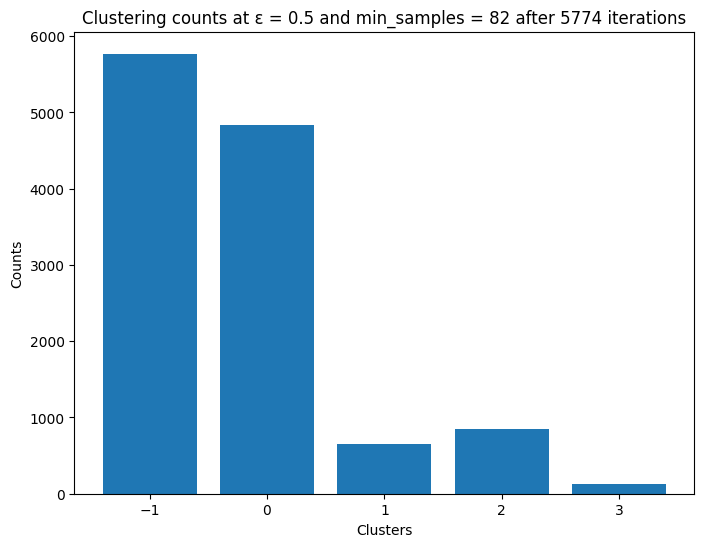



Clusters distribution

+-----------+-----------+

|   Cluster |   Samples |

|-----------+-----------|

|         0 |      5770 |

|         1 |      4841 |

|         2 |       651 |

|         3 |       853 |

|         4 |       131 |

+-----------+-----------+



Accuracy measures

+-----------+-------------+----------+-----------+

|   Cluster |   Precision |   Recall |   F-Score |

|-----------+-------------+----------+-----------|

|         0 |    0.464471 | 1        | 0.63432   |

|         1 |    1        | 0.689601 | 0.816289  |

|         2 |    1        | 0.092735 | 0.16973   |

|         3 |    1        | 0.12151  | 0.21669   |

|         4 |    1        | 0.018661 | 0.0366382 |

+-----------+-------------+----------+-----------+



F1-Score: 0.3747333083491989

Clustering conditional entropy: 0.7146384994491659


In [79]:
n_iterations = dbscan.n_iterations_

print(f'DBSCAN where ε = {dbscan.eps} and min_samples = {dbscan.min_samples} after {dbscan.execution_time}s:\n')

lables , counts = np.unique(dbscan.labels,return_counts=True)
n_clusters = len(labels)

plot(labels,counts,f'Clustering counts at ε = {dbscan.eps} and min_samples = {dbscan.min_samples} after {n_iterations} iterations')

precisions,recalls,fscores = accuracy_scores(ground_truthN,dbscan.labels)
data = []
dist = []
for i in range(n_clusters):
  dist.append([i,counts[i]])
  data.append([i,precisions[i],recalls[i],fscores[i]])

print("\nClusters distribution")
print(f'{tabulate(dist, headers=["Cluster", "Samples"],tablefmt="psql")}')
    
print("\nAccuracy measures")
print(f'{tabulate(data, headers=["Cluster", "Precision", "Recall", "F-Score"],tablefmt="psql")}')
print(f'\nF1-Score: {np.sum(fscores/n_clusters)}')
print(f'Clustering conditional entropy: {conditional_entropy(ground_truthN,dbscan.labels)}')